# Analysis of dynamical polarizability of $C_{60}$ in the linear response formalism

We analyze the computation of the dynamical polarizabilityi inside the linear response formalism.

The aim of this notebook is to:

* compute the Casida matrix associated to the highest value of virtual orbitals. 
* build the matrices associated to a lower number of virtual orbitals (by extracting its elements from the highest one) and discuss the rate of convergence of the statical polarizability to the reference value (formerly computed by including an explicit electric field). 
* evaluate the dynamical polarizability spectrum and discuss its stability in function of the number of virtual orbitals considered.  

In [2]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
#import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


First of all we compute the coupling matrix

In [3]:
inp0 = {'dft' : 
        {'hgrids': 0.40,
         'gnrm_cv' : 1e-8,
         'itermax' : 100,
         'inputpsiid': 2},
        'tddft':{'tddft_approach': 'full'},
        'posinp': 'C60_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

In [4]:
virtMax = 112
rVal = 7.0

In [5]:
inp={'dft':
     {'rmult': [rVal, 9.0],
      'itermax_virt' : 1},
     'output': {
      'orbitals' : 'No',
      'verbosity' : 3}, 
     'radical': 'Rmult_7.0'}

inp['dft']['norbv'] = -virtMax
inpname = 'NumVirt_'+str(virtMax)
Yaml.dump(inp,outputpath + inpname + '.yaml')

We execute the input file and copy the coupling matrix and transition dipoles in the "TDDFT-Results" folder with the name coupling_matrix_n and transition_dipoles_n

In [6]:
code=C.SystemCalculator(omp=3,mpi=4)
%cd $outputpath
code.run(name='NumVirt_'+str(virtMax),skip=True,outdir='./log/')
%cd ../

/local/genovese/LR-nb/POLARIZABILITY/C60/linear-response
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -n NumVirt_112 -d ./log/ -s Yes
/local/genovese/LR-nb/POLARIZABILITY/C60


Read the dipoles and coupling matrix

In [7]:
import pandas as pd

In [8]:
%cd $outputpath
dpath = 'transition_dipoles.txt'
dipoles = np.mat(pd.read_csv(dpath,delim_whitespace=True,header=None))#np.loadtxt(dpath)
cpath = 'coupling_matrix.txt'
C = np.mat(pd.read_csv(cpath,delim_whitespace=True,header=None))#np.loadtxt(cpath)
%cd ..

/local/genovese/LR-nb/POLARIZABILITY/C60/linear-response
/local/genovese/LR-nb/POLARIZABILITY/C60


We observe that $C$ is a symmetric matrix

In [9]:
np.allclose(C,C.T,atol=1.e-12)

True

In [10]:
print 120*112*2
C2=np.asarray(C)
C2[0].shape
C=np.asarray(C)

26880


In [11]:
dipoles=np.asarray(dipoles)

### Analysis of the statical polarizability

We discuss the convergence of the static polarizability to its reference value obtained with the explicit electric field.
We make use of the "extract_subset" routine to build coupling matrix and dipoles corresponding to a given set of virtual orbitals.

In [12]:
eigenproblems={}

In [22]:
alphaX = []
alphaY = []
alphaZ = []
virt = [8,16,24, 32, 48, 64]#, 80, 96,virtMax]
for nind,nval in enumerate(virt):
    print 'treating',nval
    C_ext,dipoles_ext=R.extract_subset([120],[virtMax],C,dipoles,[nval])
    print 'extracted',nval

    if nval not in eigenproblems:
        E2,C_E2=np.linalg.eigh(C_ext)
        print 'diagonalized',nval
        eigenproblems[nval]=(E2,C_E2)
    else:
        E2,C_E2=eigenproblems[nval]
    sumx = 0.0
    sumy = 0.0
    sumz = 0.0
    for i,e in enumerate(E2):
        a = np.dot(C_E2.T[i],dipoles_ext)
        sumx+=2.0*a[0]*a[0]/e
        sumy+=2.0*a[1]*a[1]/e
        sumz+=2.0*a[2]*a[2]/e
    alphaX.append(sumx)
    alphaY.append(sumy)
    alphaZ.append(sumz)
print alphaX
#print alphaY #to check if it equal to alphaX, ok!
print alphaZ

treating 8
extracted 8
treating 16
extracted 16
treating 24
extracted 24
treating 32
extracted 32
treating 48
extracted 48
treating 64
extracted 64
diagonalized 64
[338.25799043172663, 389.14261359628625, 399.70771716082311, 415.22060191800728, 453.55099881924883, 474.20662748783536]
[340.37326802309059, 388.81838985311549, 399.71438799552612, 417.55721722996424, 453.14659387380226, 474.00967697560219]


In [23]:
alphaX_ref = 561.59
alphaZ_ref = 561.59

In [24]:
alphaX_norm = [i/alphaX_ref for i in alphaX]
alphaZ_norm = [i/alphaZ_ref for i in alphaZ]

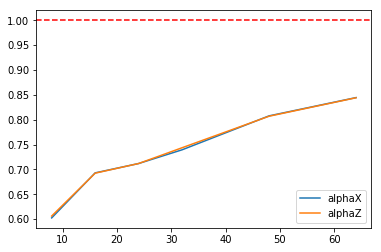

In [25]:
plt.plot(virt,alphaX_norm,label='alphaX')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.plot(virt,alphaZ_norm,label='alphaZ')
plt.legend()
plt.show()

### Dynamical polarizability in the adiabatic case

We plot the imaginary part of (minus) $A(\omega_0)$ using the coupling matrix e transition dipoles in function of the number of virtual orbitals considered in the computation. In particular we want to compare results for numVirt = 64,128,virtMax

In [26]:
npoint = 1000
eta = 1.0e-2
omega = []
A = []
#virt = [8,16,32,64,128,256,virtMax] #use previous one
for ii,nVal in enumerate(virt):
    C_ext,dipoles_ext=R.extract_subset([120],[virtMax],C,dipoles,[nVal])
    E2,C_E2=eigenproblems[nVal]#np.linalg.eigh(C_ext)
    omegaMax = np.sqrt(E2[-1]) #square root of the highest eigenvalues
    print 'lenE2', len(E2), 'omegaMax', omegaMax
    omega.append(np.linspace(0.0,omegaMax,npoint))
    A_nVirt = np.zeros(npoint, dtype=complex)
    fE = []
    for i in range(len(E2)):
        fE.append(np.dot(C_E2.T[i],dipoles_ext[:,2]))
    for ind,o in enumerate(omega[ii]):
        s = 0.0
        for i,e in enumerate(E2):
            s+=fE[i]**2/(complex(o,2*eta)**2-e)
        A_nVirt[ind] = s
    A.append(-np.imag(A_nVirt))

lenE2 1920 omegaMax 0.812307233246
lenE2 3840 omegaMax 0.873417275485
lenE2 5760 omegaMax 0.888950371069
lenE2 7680 omegaMax 0.916372909789
lenE2 11520 omegaMax 0.963775438116
lenE2 15360 omegaMax 0.993015807528


In [27]:
omega_ev = []
for i in range(len(omega)):
    omega_ev.append(27.211*omega[i])

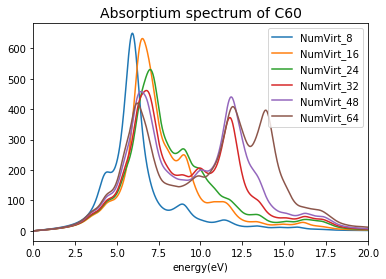

In [29]:
%matplotlib inline
##%matplotlib auto 
for i in range(0,len(virt)):
    plt.plot(omega_ev[i],A[i],label='NumVirt_'+str(virt[i]))
plt.legend()
plt.xlabel('energy(eV)')
plt.title('Absorptium spectrum of C60', fontsize=14)
plt.xlim([0,20])
plt.show()

# Density of states of the optical excitations
We can plot in the following the values of the energies of the Casida matrix to understand how the continuum plays a role in the identification of the excitation energies.

In [31]:
evals=[]
#virt = [8,16,32,64,128,256,virtMax]
for ii,nVal in enumerate(virt):
    #C_ext,dipoles_ext=R.extract_subset([120],[virtMax],C,dipoles,[nVal])
    E2,C_E2=eigenproblems[nVal] #np.linalg.eigh(C_ext)
    evals.append(E2)
    print 'done',np.max(E2)

done 0.659843041184
done 0.762857737116
done 0.790232762224
done 0.839739309796
done 0.928863095116
done 0.986080394001


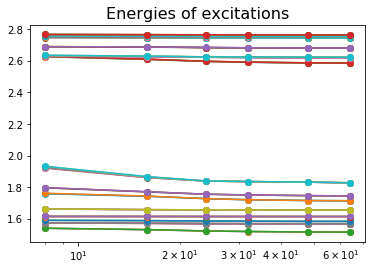

In [34]:
for e in range(0,64):
    plt.semilogx(virt[0:],[27.21138*np.sqrt(ev[e]) for ev in evals[0:]],'-o')
    #plt.scatter(dimBox,enOrbEx[orb])
    title = 'Energies of excitations'
    plt.title(title,fontsize=16)
plt.show()